In [15]:
import scipy.cluster.hierarchy as sch
import numpy as np
import pandas as pd
import pyfolio as pf
import quantstats as qs
import sklearn.covariance
from datetime import date
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import cvxopt as opt
from cvxopt import blas, solvers
import ffn
import config
from numpy.linalg import inv
solvers.options['show_progress'] = False

In [3]:
import seaborn as sns 
from pandas_datareader import data as web
import warnings
warnings.filterwarnings('ignore')

In [4]:
# On 20151227 by MLdP <lopezdeprado@lbl.gov>
# Hierarchical Risk Parity

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp


def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar


def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()


def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w


def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist


def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

In [6]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

In [7]:
symbols = ['PG', 'MSFT', 'JPM', 'TMF', 'UPRO']

In [8]:
def get_symbols(symbols,data_source,ohlc,begin_date=None,end_date=None):
    out = []
    new_symbols = []
    for symbol in symbols:
        df = web.DataReader(symbol, data_source,begin_date, end_date)\
        [['High','Low','Open','Close','Volume','Adj Close']]
        new_symbols.append(symbol) 
        out.append(df[ohlc].astype('float'))
        data = pd.concat(out, axis = 1)
        data.columns = new_symbols
    return data

In [9]:
start = pd.Timestamp('2014-01-01')

end = pd.Timestamp('2020-01-06')

In [10]:
prices = get_symbols(symbols,data_source='yahoo',ohlc='Close',\
                     begin_date=start,end_date=end)

SPY = get_symbols('SPY',data_source='yahoo',ohlc='Close',\
                     begin_date=start,end_date=end)

In [11]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1514 entries, 2014-01-02 to 2020-01-07
Data columns (total 5 columns):
PG      1514 non-null float64
MSFT    1514 non-null float64
JPM     1514 non-null float64
TMF     1514 non-null float64
UPRO    1514 non-null float64
dtypes: float64(5)
memory usage: 71.0 KB


In [12]:
rets = prices.pct_change().dropna()
rets.head()

,PG,MSFT,JPM,TMF,UPRO
Date,,,,,
2014-01-03,-0.001118,-0.006728,0.007731,0.000454,-0.001710
2014-01-06,0.002362,-0.021132,0.005796,0.009532,-0.006638
2014-01-07,0.009673,0.007750,-0.011525,0.008543,0.017353
2014-01-08,-0.014493,-0.017852,0.009431,-0.007356,0.001059
2014-01-09,0.002243,-0.006432,-0.001869,0.015720,0.000741


In [13]:
pricesx = prices.copy()
pricesx['SPY'] = SPY.Y
retx = pricesx.pct_change().dropna()

# EDA

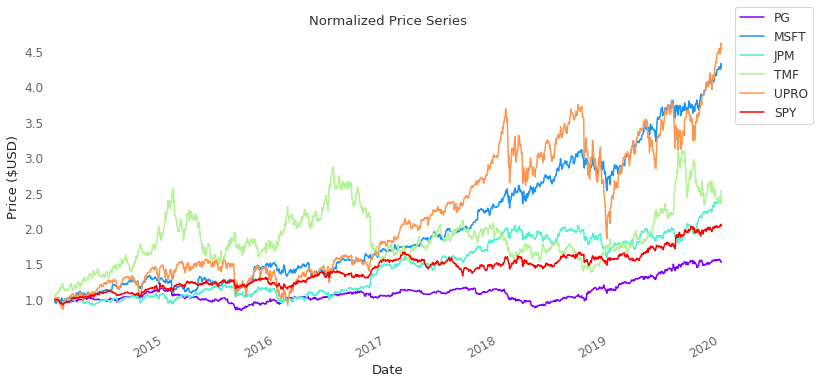

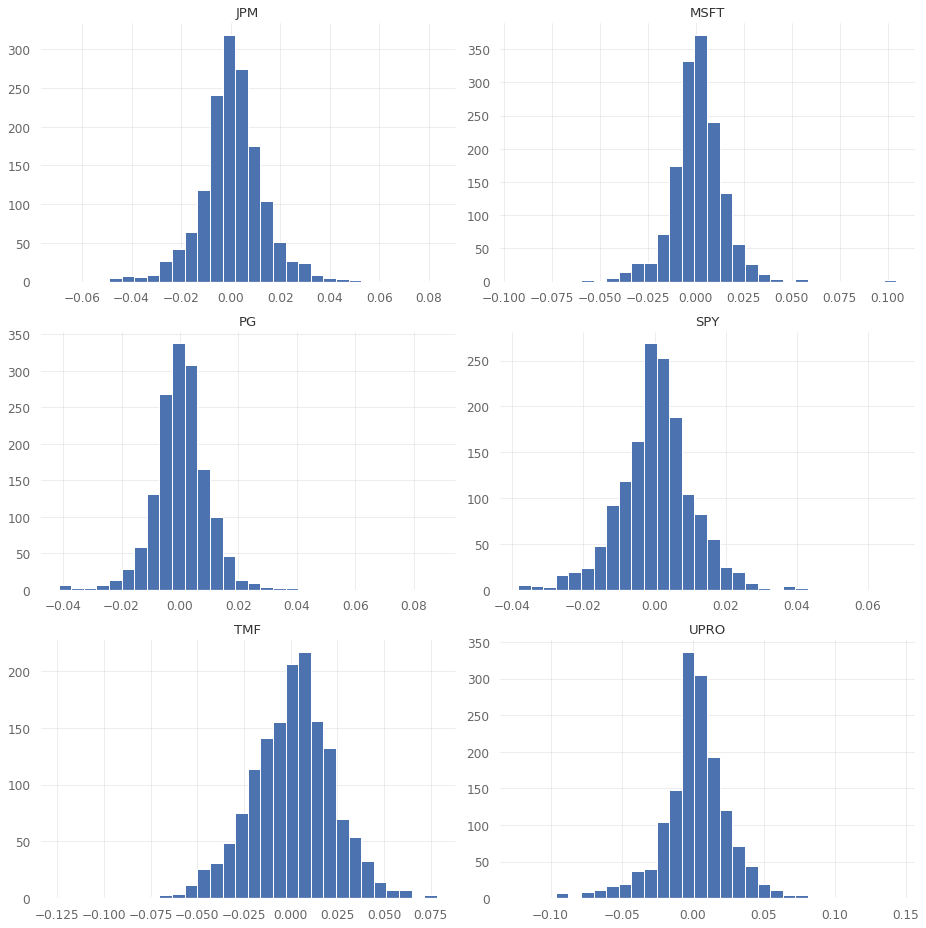

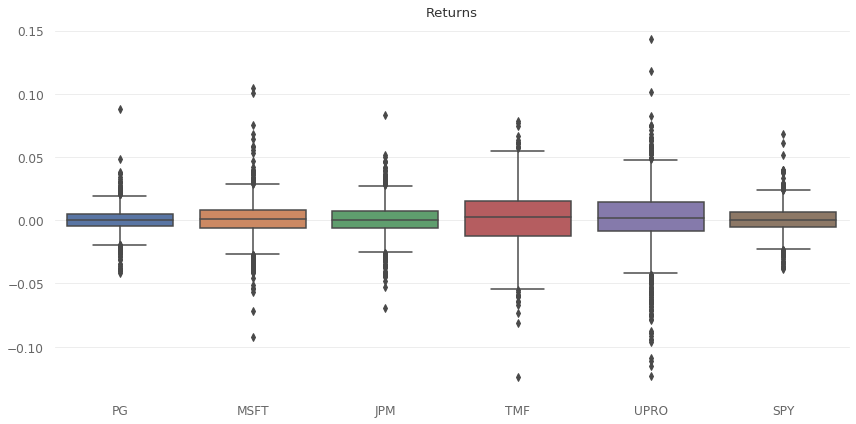

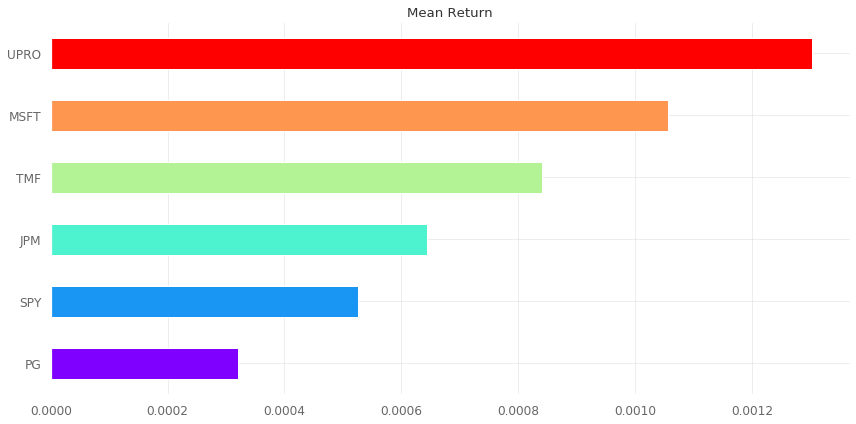

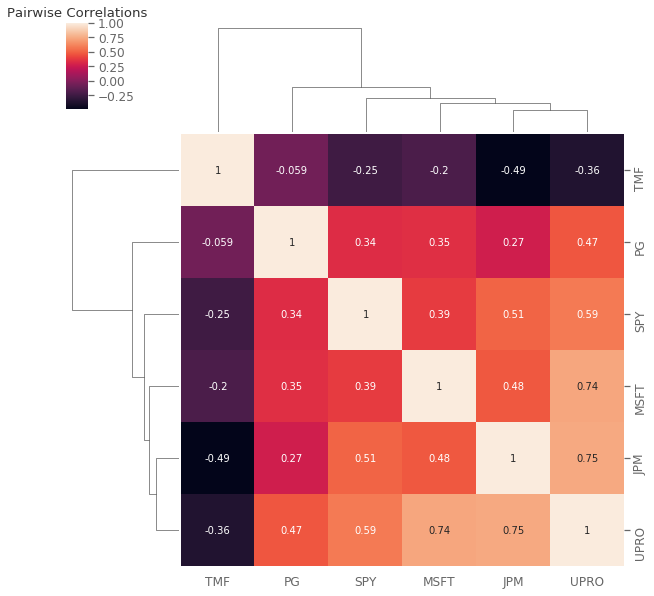

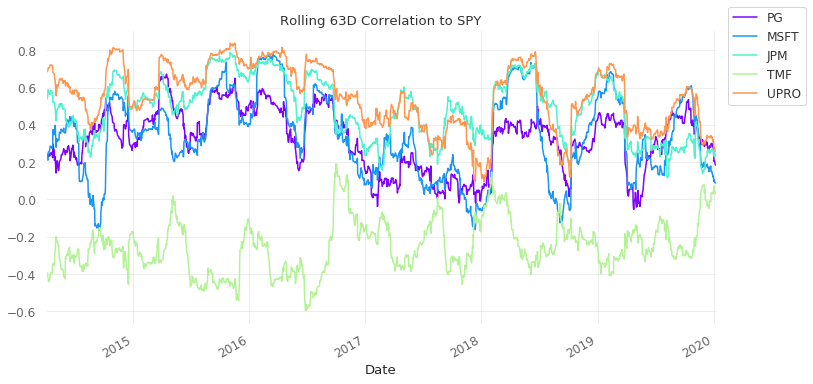

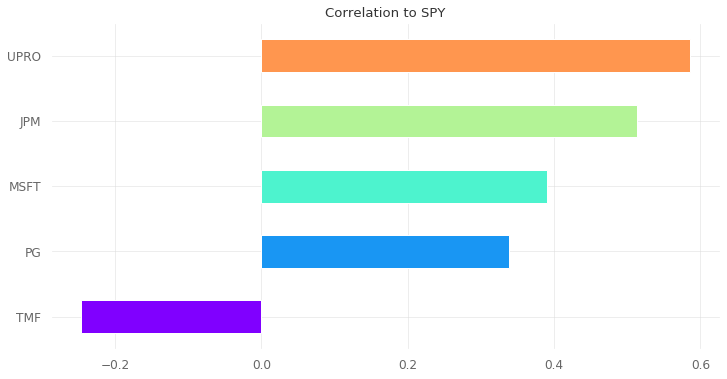

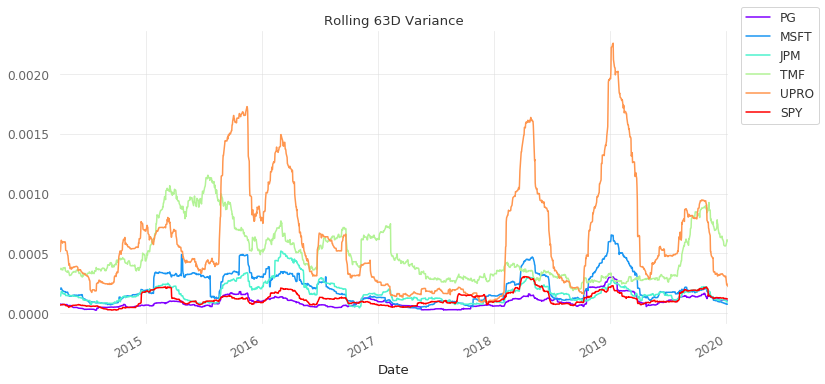

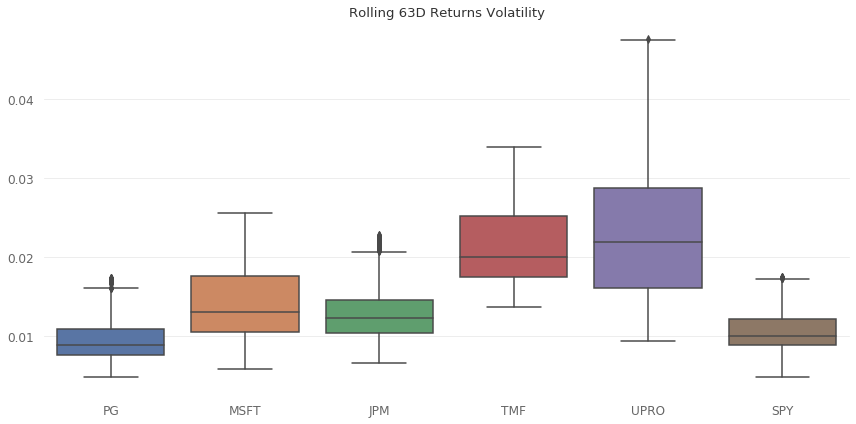

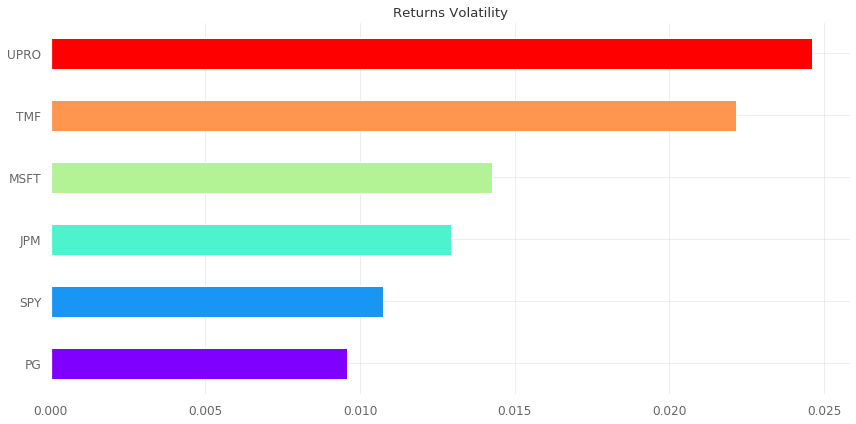

In [14]:
n_secs = len(pricesx.columns)
colors = cm.rainbow(np.linspace(0, 1, n_secs))
pricesx.div(pricesx.iloc[0,:]).plot(color=colors, figsize=(12, 6))# Normalize Prices 
plt.title('Normalized Price Series')
plt.xlabel('Date')
plt.ylabel('Price ($USD)')
plt.grid(b=None, which=u'major', axis=u'both')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

pricesx.pct_change().dropna().hist(bins=30, figsize=(13,13))
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=retx)
plt.title('Returns')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
retx.mean().sort_values(ascending=True).plot(kind='barh',colors=colors)
plt.title('Mean Return')
plt.tight_layout()
plt.show()

g = sns.clustermap(retx.corr(), annot=True)
ax = g.ax_heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pairwise Correlations')
plt.show()

retx.drop('SPY',axis=1).rolling(63).corr(retx.SPY).dropna().plot(color=colors, figsize=(12, 6))
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.title('Rolling 63D Correlation to SPY')
plt.show()

retx.drop('SPY',axis=1).corrwith(retx.SPY).sort_values(ascending=True).plot(kind='barh', color=colors, figsize=(12, 6))
plt.title('Correlation to SPY')
plt.show()

retx.rolling(63).var().dropna().plot(color=colors, figsize=(12, 6))
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.title('Rolling 63D Variance')
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=retx.rolling(63).std().dropna())
plt.title('Rolling 63D Returns Volatility')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
retx.std().sort_values(ascending=True).plot(kind='barh',colors=colors)
plt.title('Returns Volatility')
plt.tight_layout()
plt.show()

In [17]:
X = retx[['PG', 'MSFT', 'JPM', 'TMF', 'UPRO']]
#X1 = retx[['UPRO', 'TMF', 'QQQ', 'XLK', 'XLF', 'DIA']]
y = retx['SPY']

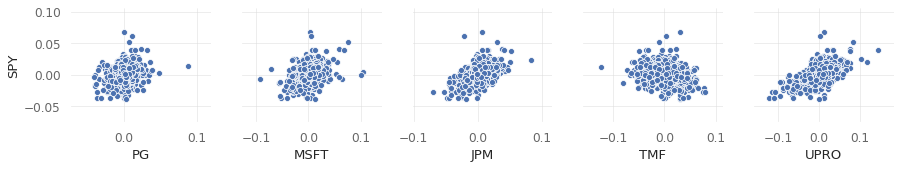

In [18]:
sns.pairplot(X.assign(SPY=y), y_vars=['SPY'], x_vars=X.columns)
plt.show();
#sns.pairplot(X1.assign(SPY=y), y_vars=['SPY'], x_vars=X1.columns)
#plt.show()

# Expanding window

In [19]:
MVP_Ret = []
IVP_Ret = []
HRP_Ret = []

MVP_Wt = []
IVP_Wt = []
HRP_Wt = []

X = rets
n_train = 21
n_records = len(X)

for i in range(n_train, n_records, 21):
    
    train, test = X[0:i], X[i:i+21]
    #train, test = X[i-n_train:i], X[i:i+63]
    
    print()
    print(f'Training on {len(train)} records', train)
    print()
    print(f'Testing on {len(test)} records', test)
    print()
    
    corr = train.corr(method='spearman')
    cov = train.cov()
    
    hrp = getHRP(cov, corr)
    ivp = getIVP(cov)
    ivp = pd.Series(ivp, index=cov.index)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    
    portfolios = pd.DataFrame([mvp, ivp, hrp], index=['MVP', 'IVP', 'HRP']).T

    MVP_weights = portfolios.MVP.values
    IVP_weights = portfolios.IVP.values
    HRP_weights = portfolios.HRP.values

    MVP_Returns = test.mul(MVP_weights, axis=1)
    MVP_Returns = MVP_Returns.sum(axis=1)
    
    IVP_Returns = test.mul(IVP_weights, axis=1)
    IVP_Returns = IVP_Returns.sum(axis=1)

    HRP_Returns = test.mul(HRP_weights, axis=1)
    HRP_Returns = HRP_Returns.sum(axis=1)
    
    MVP_Ret.append(MVP_Returns)
    IVP_Ret.append(IVP_Returns)
    HRP_Ret.append(HRP_Returns)
    
    MVP_Wt.append(portfolios.MVP)
    IVP_Wt.append(portfolios.IVP)
    HRP_Wt.append(portfolios.HRP)
    
    wt1z = pd.concat(MVP_Wt, axis=1).T.reset_index(drop=True)
    wt2z = pd.concat(IVP_Wt, axis=1).T.reset_index(drop=True)
    wt3z = pd.concat(HRP_Wt, axis=1).T.reset_index(drop=True)

    data1z = pd.concat(MVP_Ret)
    data2z = pd.concat(IVP_Ret)
    data3z = pd.concat(HRP_Ret) 


Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
2014-01-10 -0.001492  0.014354 -0.004595  0.035817  0.008566
2014-01-13 -0.003611 -0.029412 -0.013507  0.015795 -0.038901
2014-01-14  0.010749  0.022870  0.000693 -0.014289  0.031202
2014-01-15 -0.000989  0.027390  0.030308 -0.001705  0.016610
2014-01-16 -0.002847  0.003536 -0.008405  0.017510 -0.004163
2014-01-17 -0.008441 -0.013825 -0.014918  0.012802 -0.012959
2014-01-21  0.003756 -0.005772  0.001032  0.002279  0.008788
2014-01-22 -0.011848 -0.006635 -0.009971 -0.006202  0.002204
2014-01-23 -0.012495  0.003618 -0.019448  0.042646 -0.023982



Training on 84 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
...              ...       ...       ...       ...       ...
2014-04-29 -0.006028 -0.008808  0.010993 -0.003705  0.014028
2014-04-30  0.001334 -0.002715 -0.002139  0.010802  0.009952
2014-05-01 -0.002544 -0.009901 -0.004644  0.028732 -0.000493
2014-05-02 -0.005101 -0.007750 -0.002513  0.022139 -0.004042
2014-05-05 -0.002686 -0.006551 -0.024469 -0.017994  0.005246

[84 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-05-06 -0.0


Training on 168 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
...              ...       ...       ...       ...       ...
2014-08-27 -0.000840 -0.003110 -0.002511  0.025720 -0.001063
2014-08-28 -0.003361  0.000223 -0.007216  0.015529 -0.002129
2014-08-29  0.000964  0.012255  0.004902  0.002806  0.008122
2014-09-02 -0.001564 -0.007484  0.003701 -0.052602 -0.002034
2014-09-03 -0.000964 -0.002883  0.000503  0.016686 -0.000571

[168 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-09-04  0


Training on 273 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
...              ...       ...       ...       ...       ...
2015-01-28 -0.015493 -0.034459 -0.025801  0.048762 -0.040728
2015-01-29  0.006107  0.019908  0.016804 -0.019037  0.029679
2015-01-30 -0.016108 -0.038324 -0.023172  0.051689 -0.038831
2015-02-02  0.009847  0.021782  0.020044 -0.009404  0.036568
2015-02-03  0.009751  0.007752  0.022535 -0.063944  0.043716

[273 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2015-02-04 -0


Training on 357 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
...              ...       ...       ...       ...       ...
2015-05-29 -0.011849 -0.012434 -0.006344  0.006157 -0.019659
2015-06-01  0.005868  0.007896  0.004561 -0.032381  0.006496
2015-06-02 -0.003931 -0.006564 -0.000908 -0.042161 -0.002806
2015-06-03  0.000255 -0.001492  0.010300 -0.046767  0.007739
2015-06-04 -0.005219 -0.010459 -0.005547  0.037229 -0.023178

[357 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2015-06-05 -0


Training on 462 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
...              ...       ...       ...       ...       ...
2015-10-27 -0.002581 -0.010323 -0.004069  0.007811 -0.007324
2015-10-28 -0.010092  0.005401  0.029227 -0.011564  0.034583
2015-10-29  0.006666 -0.011486 -0.004427 -0.046297 -0.000149
2015-10-30 -0.008310 -0.013493 -0.014722  0.020227 -0.015453
2015-11-02  0.002880  0.011398  0.020078 -0.013047  0.035768

[462 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2015-11-03  0


Training on 546 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
...              ...       ...       ...       ...       ...
2016-02-29 -0.009988 -0.008187 -0.021550  0.008920 -0.027259
2016-03-01  0.011708  0.033412  0.051510 -0.048732  0.074280
2016-03-02  0.016250  0.007037  0.009459  0.011064  0.013757
2016-03-03  0.003513 -0.011331  0.003347  0.011272  0.010222
2016-03-04  0.007846 -0.006113  0.001501 -0.019370  0.010642

[546 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2016-03-07 -0


Training on 630 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
...              ...       ...       ...       ...       ...
2016-06-28  0.015142  0.020855  0.033154  0.004444  0.054199
2016-06-29  0.017584  0.022249  0.028226 -0.021686  0.052398
2016-06-30  0.009057  0.012465  0.015359  0.008778  0.038864
2016-07-01  0.001299 -0.000195 -0.014162  0.043509  0.007061
2016-07-05  0.007785  0.000195 -0.027914  0.036388 -0.020289

[630 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2016-07-06 -0


Training on 735 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
...              ...       ...       ...       ...       ...
2016-11-25  0.009434  0.002152 -0.000380  0.003224  0.011472
2016-11-28 -0.004673  0.001322 -0.006470  0.023032 -0.014145
2016-11-29 -0.002167  0.007919  0.007661  0.010471  0.005688
2016-11-30 -0.005188 -0.013587  0.015839 -0.053368 -0.007969
2016-12-01 -0.007276 -0.017590  0.020207 -0.024083 -0.011532

[735 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2016-12-02  0


Training on 819 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
...              ...       ...       ...       ...       ...
2017-03-29 -0.001763  0.002757 -0.003725  0.018192  0.004607
2017-03-30 -0.004415  0.003666  0.008610 -0.023647  0.007817
2017-03-31 -0.003880  0.002283 -0.013366  0.007535 -0.007033
2017-04-03 -0.001892 -0.004707 -0.003643  0.030449 -0.003854
2017-04-04  0.002565  0.002746 -0.002399 -0.016589  0.001673

[819 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2017-04-05  0


Training on 903 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
...              ...       ...       ...       ...       ...
2017-07-28 -0.005183 -0.001640 -0.002949  0.018481 -0.004700
2017-07-31  0.006762 -0.004655  0.005697  0.002452 -0.001362
2017-08-01  0.003083 -0.001651  0.013399  0.020548  0.005911
2017-08-02 -0.000659 -0.004409  0.000860  0.001917  0.001175
2017-08-03 -0.001977 -0.001522 -0.006551  0.032057 -0.004695

[903 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2017-08-04 -0


Training on 1008 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
...              ...       ...       ...       ...       ...
2017-12-27 -0.004109  0.003630  0.001869  0.038136  0.002134
2017-12-28 -0.000326  0.000117  0.005316 -0.001360  0.004614
2017-12-29 -0.002064 -0.002100 -0.007886  0.004087 -0.009681
2018-01-02 -0.013387  0.004793  0.009444 -0.033017  0.020478
2018-01-03 -0.001213  0.004654  0.001019  0.012161  0.018249

[1008 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2018-01-04 


Training on 1113 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
...              ...       ...       ...       ...       ...
2018-05-30  0.011344  0.009591  0.022845 -0.020325  0.038183
2018-05-31 -0.022967 -0.001112 -0.012367 -0.005187 -0.020714
2018-06-01  0.003827  0.019729  0.012989 -0.015120  0.031513
2018-06-04  0.009939  0.008731  0.000461 -0.022234  0.014229
2018-06-05 -0.002831  0.005115 -0.005625  0.008121  0.002888

[1113 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2018-06-06 


Training on 1197 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
...              ...       ...       ...       ...       ...
2018-09-27 -0.004804  0.003773 -0.004347  0.001144  0.008089
2018-09-28  0.004465 -0.000350 -0.014670 -0.009143 -0.001047
2018-10-01  0.005286  0.010842  0.005849 -0.021915  0.011350
2018-10-02  0.008247 -0.003979  0.004141  0.019458 -0.001036
2018-10-03 -0.015766  0.000174  0.009388 -0.053210  0.001383

[1197 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2018-10-04 


Training on 1302 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
...              ...       ...       ...       ...       ...
2019-03-01 -0.001116  0.004463  0.000671 -0.028002  0.019962
2019-03-04  0.004368 -0.002399 -0.002298  0.024377 -0.011868
2019-03-05  0.002225 -0.004988 -0.000768  0.005949 -0.004214
2019-03-06 -0.001615  0.000448 -0.003746  0.010215 -0.018409
2019-03-07 -0.003841 -0.012170 -0.007231  0.020223 -0.025005

[1302 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2019-03-08 


Training on 1407 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
...              ...       ...       ...       ...       ...
2019-07-31 -0.019683 -0.029070  0.003547  0.024610 -0.034524
2019-08-01 -0.011098  0.013136 -0.026379  0.058046 -0.025262
2019-08-02 -0.002484 -0.008402 -0.000089  0.025728 -0.021719
2019-08-05 -0.028856 -0.034258 -0.029753  0.053855 -0.088992
2019-08-06  0.010612  0.018758  0.007849  0.021701  0.038296

[1407 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2019-08-07 

# 21d sliding window

In [20]:
MVP_Ret = []
IVP_Ret = []
HRP_Ret = []

MVP_Wt = []
IVP_Wt = []
HRP_Wt = []

X = rets
n_train = 21
n_records = len(X)

for i in range(n_train, n_records, 21):
    
    #train, test = X[0:i], X[i:i+21]
    train, test = X[i-n_train:i], X[i:i+21]
    
    print()
    print(f'Training on {len(train)} records', train)
    print()
    print(f'Testing on {len(test)} records', test)
    print()
    
    corr = train.corr(method='spearman')
    cov = train.cov()
    
    hrp = getHRP(cov, corr)
    ivp = getIVP(cov)
    ivp = pd.Series(ivp, index=cov.index)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    
    portfolios = pd.DataFrame([mvp, ivp, hrp], index=['MVP', 'IVP', 'HRP']).T

    MVP_weights = portfolios.MVP.values
    IVP_weights = portfolios.IVP.values
    HRP_weights = portfolios.HRP.values

    MVP_Returns = test.mul(MVP_weights, axis=1)
    MVP_Returns = MVP_Returns.sum(axis=1)
    
    IVP_Returns = test.mul(IVP_weights, axis=1)
    IVP_Returns = IVP_Returns.sum(axis=1)

    HRP_Returns = test.mul(HRP_weights, axis=1)
    HRP_Returns = HRP_Returns.sum(axis=1)
    
    MVP_Ret.append(MVP_Returns)
    IVP_Ret.append(IVP_Returns)
    HRP_Ret.append(HRP_Returns)
    
    MVP_Wt.append(portfolios.MVP)
    IVP_Wt.append(portfolios.IVP)
    HRP_Wt.append(portfolios.HRP)
    
    wt11 = pd.concat(MVP_Wt, axis=1).T.reset_index(drop=True)
    wt21 = pd.concat(IVP_Wt, axis=1).T.reset_index(drop=True)
    wt31 = pd.concat(HRP_Wt, axis=1).T.reset_index(drop=True)

    data11 = pd.concat(MVP_Ret)
    data21 = pd.concat(IVP_Ret)
    data31 = pd.concat(HRP_Ret) 


Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
2014-01-10 -0.001492  0.014354 -0.004595  0.035817  0.008566
2014-01-13 -0.003611 -0.029412 -0.013507  0.015795 -0.038901
2014-01-14  0.010749  0.022870  0.000693 -0.014289  0.031202
2014-01-15 -0.000989  0.027390  0.030308 -0.001705  0.016610
2014-01-16 -0.002847  0.003536 -0.008405  0.017510 -0.004163
2014-01-17 -0.008441 -0.013825 -0.014918  0.012802 -0.012959
2014-01-21  0.003756 -0.005772  0.001032  0.002279  0.008788
2014-01-22 -0.011848 -0.006635 -0.009971 -0.006202  0.002204
2014-01-23 -0.012495  0.003618 -0.019448  0.042646 -0.023982



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-04-04 -0.004120 -0.027798 -0.014013  0.019349 -0.034772
2014-04-07  0.009026 -0.001756 -0.013543  0.019169 -0.034305
2014-04-08  0.010685  0.000503 -0.002542  0.005716  0.013308
2014-04-09  0.001721  0.016323  0.007137 -0.013201  0.032161
2014-04-10 -0.004909 -0.027428 -0.031551  0.027313 -0.063421
2014-04-11 -0.004069 -0.003811 -0.036585  0.023151 -0.027172
2014-04-14  0.000619 -0.000765 -0.006148 -0.006717  0.023312
2014-04-15  0.000371  0.014548 -0.002911  0.016373  0.020632
2014-04-16  0.010020  0.016352  0.008394  0.005428  0.031480
2014-04-17  0.001347 -0.009654 -0.000724 -0.033786  0.003879
2014-04-21 -0.002446 -0.001750 -0.003441 -0.002343  0.011388
2014-04-22 -0.003801  0.001252  0.014174  0.011382  0.012466
2014-04-23 -0.010954 -0.007502  0.004300  0.016792 -0.006156
2014-04-24  0.009831  0.004283  0.002498  0.005271  0.005995



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-07-07  0.002626  0.004546 -0.006661  0.020899 -0.009901
2014-07-08  0.004614 -0.005001 -0.016058  0.033095 -0.019068
2014-07-09  0.013779 -0.002633  0.004663  0.002972  0.012527
2014-07-10 -0.000735  0.000480 -0.008211  0.000165 -0.012031
2014-07-11 -0.005514  0.009595  0.004320  0.019095  0.004750
2014-07-14  0.001971  0.001188  0.008781 -0.013407  0.014011
2014-07-15 -0.000738  0.007356  0.035175 -0.005566 -0.005171
2014-07-16 -0.003938  0.038398  0.007551  0.016464  0.010907
2014-07-17 -0.006672  0.010209 -0.014478  0.037253 -0.034305
2014-07-18  0.001866  0.003593  0.006395 -0.008745  0.030462
2014-07-21 -0.003352  0.003356  0.000172  0.013863 -0.006099
2014-07-22 -0.002242 -0.000223  0.007383  0.006370  0.013465
2014-07-23 -0.001373  0.000892  0.005625 -0.004632  0.006727
2014-07-24  0.003375 -0.010475  0.002881 -0.021405  0.000251



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-10-03  0.008910  0.007212  0.024813  0.011340  0.033135
2014-10-06 -0.002626  0.000000 -0.001990  0.001438 -0.003697
2014-10-07 -0.004906 -0.012150 -0.015121  0.041344 -0.045655
2014-10-08  0.012265  0.027454  0.019065  0.000414  0.052541
2014-10-09 -0.006177 -0.019880 -0.021854 -0.012540 -0.060658
2014-10-10  0.012312 -0.039695 -0.009479  0.029305 -0.034025
2014-10-13 -0.015586 -0.008630 -0.006152  0.018574 -0.049332
2014-10-14  0.002159  0.001833 -0.002923  0.018368  0.005179
2014-10-15 -0.007181 -0.011662 -0.042421  0.023657 -0.024376
2014-10-16 -0.008559 -0.011106 -0.008104 -0.017365 -0.000609
2014-10-17  0.012524  0.020824  0.020334 -0.015722  0.037602
2014-10-20  0.010928  0.010314  0.007651  0.008581  0.028306
2014-10-21  0.005108  0.018149  0.022956 -0.022906  0.059053
2014-10-22 -0.004491 -0.011141 -0.008286  0.001072 -0.020865



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2015-01-05 -0.004755 -0.009196 -0.031045  0.048145 -0.053837
2015-01-06 -0.004555 -0.014677 -0.025929  0.053249 -0.027092
2015-01-07  0.005246  0.012705  0.001526 -0.005209  0.036882
2015-01-08  0.011436  0.029418  0.022346 -0.039322  0.052761
2015-01-09 -0.009330 -0.008405 -0.017387  0.033344 -0.024532
2015-01-12 -0.003657 -0.012503 -0.008595  0.016651 -0.024146
2015-01-13  0.004226 -0.005150  0.000170 -0.000102 -0.008221
2015-01-14 -0.003433 -0.008628 -0.034500  0.021569 -0.017535
2015-01-15 -0.001445 -0.010444 -0.032037  0.049099 -0.027341
2015-01-16  0.015468  0.016711  0.017094 -0.040061  0.037284
2015-01-20 -0.000658  0.003244 -0.003934  0.039953  0.007961
2015-01-21 -0.005044 -0.010132  0.003231 -0.033853  0.014679
2015-01-22  0.009809  0.026350  0.030417 -0.012106  0.045129
2015-01-23 -0.016809  0.001061 -0.015801  0.042144 -0.017453



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2015-04-07 -0.007828 -0.000481  0.006284  0.024359 -0.008377
2015-04-08  0.004612 -0.002649  0.003287  0.000000  0.010596
2015-04-09  0.001450  0.001449  0.006880 -0.037799  0.013565
2015-04-10  0.005550  0.005786  0.003742  0.003669  0.015626
2015-04-13  0.000960  0.000959  0.005997  0.004731 -0.013035
2015-04-14  0.002038 -0.002634  0.015628  0.020869  0.005341
2015-04-15 -0.001077  0.014646  0.018560 -0.001992  0.013209
2015-04-16 -0.000120 -0.002366 -0.006230 -0.015336 -0.000921
2015-04-17 -0.011617 -0.012808 -0.015201  0.034457 -0.034537
2015-04-20  0.004120  0.030995  0.006365 -0.025884  0.027178
2015-04-21  0.002534 -0.006292 -0.014706 -0.013339 -0.003361
2015-04-22  0.000120  0.008208  0.010111 -0.047210  0.014566
2015-04-23 -0.025755  0.008141 -0.002224  0.013063  0.007567
2015-04-24  0.000618  0.104522 -0.003185  0.019453  0.007159



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2015-07-07  0.020862 -0.002027 -0.007872  0.028262  0.017878
2015-07-08 -0.008933 -0.001354 -0.020509  0.027068 -0.049473
2015-07-09 -0.004075  0.006329  0.010393 -0.059197  0.004928
2015-07-10  0.003595  0.002022  0.014219 -0.047694  0.038002
2015-07-13  0.011859  0.020847  0.015511 -0.009504  0.032625
2015-07-14  0.001587  0.001757  0.013952  0.008986  0.014010
2015-07-15  0.001341  0.003069  0.002173  0.031849 -0.001833
2015-07-16  0.001826  0.019668  0.005348  0.020772  0.022740
2015-07-17 -0.000729 -0.000857 -0.005032  0.016050  0.003176
2015-07-20 -0.000608  0.006435  0.000722 -0.012271  0.002065
2015-07-21 -0.006814  0.007673 -0.002310  0.015993 -0.012639
2015-07-22 -0.009800 -0.036802  0.014182  0.017850 -0.005983
2015-07-23 -0.001608  0.012516 -0.006279  0.037973 -0.016517
2015-07-24 -0.005080 -0.003687 -0.010482  0.008115 -0.030316



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2015-10-05  0.011047  0.023261  0.019898 -0.038302  0.055029
2015-10-06  0.002458  0.002573  0.000484  0.011035 -0.010363
2015-10-07  0.004360  0.001070  0.001289 -0.008907  0.025829
2015-10-08  0.009224  0.013889  0.000000 -0.024937  0.025859
2015-10-09  0.001075 -0.007165 -0.003219  0.007010  0.001824
2015-10-12 -0.002014 -0.002335 -0.003391  0.022302  0.004304
2015-10-13 -0.002960 -0.002340 -0.002754  0.004414 -0.019944
2015-10-14  0.001349 -0.004479 -0.025345  0.025361 -0.015304
2015-10-15  0.000808  0.007069  0.031672 -0.011755  0.045602
2015-10-16  0.008483  0.010636  0.008725 -0.000991  0.013558
2015-10-19  0.003471  0.002315 -0.003364 -0.007813  0.002095
2015-10-20 -0.009713  0.003150  0.004822 -0.019500 -0.004342
2015-10-21 -0.011286 -0.011932 -0.007358  0.030724 -0.017445
2015-10-22  0.017122  0.017585  0.018208  0.005318  0.049482



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2016-01-05  0.003190  0.004562  0.001729 -0.012299  0.005507
2016-01-06 -0.009667 -0.018165 -0.014436  0.040005 -0.038008
2016-01-07 -0.008734 -0.034783 -0.040439  0.005222 -0.072119
2016-01-08 -0.015678  0.003067 -0.022399  0.012798 -0.033284
2016-01-11  0.009214 -0.000573 -0.001527 -0.032278  0.001731
2016-01-12 -0.002087  0.009178  0.002210  0.043439  0.025730
2016-01-13 -0.008626 -0.021599 -0.027476  0.029488 -0.075440
2016-01-14  0.003955  0.028466  0.014998 -0.027560  0.048795
2016-01-15 -0.015364 -0.039917 -0.019931  0.047030 -0.065444
2016-01-19  0.023340 -0.008433 -0.000526 -0.009456  0.005784
2016-01-20 -0.011729  0.004549 -0.026311  0.031504 -0.037995
2016-01-21  0.011737 -0.006104 -0.004684 -0.021402  0.014517
2016-01-22  0.008342  0.035856  0.030769 -0.010285  0.063131
2016-01-25 -0.006593 -0.009562 -0.022651  0.015409 -0.044537



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2016-04-06  0.007816  0.010264  0.007711 -0.021315  0.031119
2016-04-07 -0.006801 -0.011974 -0.025336  0.036092 -0.034871
2016-04-08 -0.000481 -0.000735  0.007327 -0.018519  0.007939
2016-04-11 -0.005649 -0.002021  0.007967 -0.004284 -0.007716
2016-04-12  0.001209  0.006260  0.018557 -0.019871  0.028835
2016-04-13 -0.004467  0.012809  0.042341  0.009928  0.029287
2016-04-14 -0.005457  0.000181  0.012947 -0.013762  0.000765
2016-04-15  0.003536  0.005238 -0.011503  0.023187 -0.004586
2016-04-18  0.006440  0.014555  0.006465 -0.011177  0.021959
2016-04-19  0.005433 -0.001240  0.016862 -0.009022  0.009467
2016-04-20 -0.020773 -0.014187  0.014529 -0.033696  0.002382
2016-04-21 -0.009197  0.003418 -0.009963 -0.016894 -0.015741
2016-04-22  0.001856 -0.071710  0.005818 -0.008041  0.000603
2016-04-25  0.005683  0.006373 -0.005784 -0.011882 -0.005881



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2016-07-06 -0.004799  0.004104  0.010747  0.004551  0.016750
2016-07-07 -0.002352  0.000000  0.006480  0.000809 -0.002097
2016-07-08  0.011081  0.017906  0.020634  0.020857  0.044274
2016-07-11 -0.000233  0.005545  0.007116 -0.025340  0.010779
2016-07-12  0.000000  0.011789  0.014935 -0.046474  0.021897
2016-07-13  0.001633  0.005638 -0.000633  0.031357  0.000139
2016-07-14 -0.000233  0.004298  0.015200 -0.042961  0.015442
2016-07-15  0.001630 -0.000744  0.000936 -0.024344 -0.003014
2016-07-18 -0.000930  0.004842 -0.003428 -0.004512  0.008108
2016-07-19  0.002793 -0.016123 -0.001563  0.016443 -0.003544
2016-07-20 -0.009864  0.053117  0.001096 -0.015827  0.012859
2016-07-21 -0.000703 -0.001967 -0.003754  0.005775 -0.011615
2016-07-22  0.005395  0.013799  0.005495  0.005124  0.013528
2016-07-25  0.000933  0.002828 -0.002655 -0.002109 -0.007550



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2016-10-04 -0.003497 -0.003135  0.001353 -0.035453 -0.013847
2016-10-05  0.005659  0.006988  0.016366 -0.012126  0.013207
2016-10-06  0.004164  0.001735  0.002659 -0.016878  0.001647
2016-10-07  0.008742  0.001039  0.003536  0.001171 -0.010822
2016-10-10 -0.010444  0.004152  0.007782 -0.017537  0.015095
2016-10-11 -0.005839 -0.014645 -0.004808 -0.007933 -0.036426
2016-10-12  0.000339 -0.001399 -0.002635  0.003199  0.003681
2016-10-13 -0.003726 -0.003327 -0.005724  0.010761 -0.010157
2016-10-14  0.002153  0.008784 -0.003248 -0.040615  0.000998
2016-10-17 -0.006785 -0.003483 -0.005184  0.016852 -0.009681
2016-10-18 -0.004327  0.007690  0.007890  0.011318  0.017108
2016-10-19 -0.021841 -0.002255  0.009601  0.003197  0.008339
2016-10-20 -0.007131 -0.004867 -0.001317  0.001992 -0.005467
2016-10-21 -0.007065  0.042096  0.003369  0.005169  0.000564



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2017-01-04  0.003563 -0.004474 -0.003668  0.012589  0.017834
2017-01-05  0.006627  0.000000 -0.009205  0.046487 -0.003057
2017-01-06 -0.000353  0.008668  0.000116 -0.029442  0.011323
2017-01-09 -0.007409 -0.003183  0.000697  0.026078 -0.009447
2017-01-10 -0.010782 -0.000319  0.002901 -0.003112 -0.001648
2017-01-11  0.003114  0.009103  0.007521  0.010406  0.008138
2017-01-12  0.001075 -0.009179 -0.009646 -0.007209 -0.006551
2017-01-13  0.002028  0.001437  0.005334 -0.013485  0.006241
2017-01-17  0.014284 -0.002711 -0.036332  0.031546 -0.009245
2017-01-18 -0.003286 -0.000480  0.004668 -0.038736  0.005197
2017-01-19 -0.002708 -0.003200 -0.007624 -0.020149 -0.010458
2017-01-20  0.032468  0.007063  0.004442 -0.004870  0.010331
2017-01-23 -0.005603  0.003506  0.000478  0.029364 -0.007757
2017-01-24  0.010350  0.008895  0.012065 -0.021659  0.019071



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2017-04-05  0.000667 -0.002586 -0.012828  0.007907 -0.010125
2017-04-06 -0.006335  0.002593  0.003365 -0.002615  0.008225
2017-04-07 -0.001902 -0.000761 -0.003469 -0.013634 -0.002929
2017-04-10  0.002914 -0.002284 -0.003481  0.014354  0.001573
2017-04-11  0.003464 -0.000763 -0.001747  0.029350 -0.003561
2017-04-12  0.005679 -0.003818 -0.003849  0.015275 -0.012613
2017-04-13 -0.003100 -0.004293 -0.011710  0.010532 -0.019055
2017-04-17  0.003999  0.008160  0.017299 -0.009429  0.025285
2017-04-18  0.004536 -0.001375 -0.008153  0.039579 -0.009526
2017-04-19 -0.013216 -0.005352 -0.008220 -0.017831 -0.005129
2017-04-20 -0.003013  0.007073  0.012906 -0.010795  0.023308
2017-04-21 -0.007948  0.013740 -0.012040 -0.000992 -0.008397
2017-04-24  0.010494  0.017018  0.035258 -0.013903  0.031756
2017-04-25  0.005025  0.005775  0.008686 -0.035750  0.017544



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2017-07-06 -0.003422 -0.007383 -0.003202 -0.024543 -0.026651
2017-07-07  0.003205  0.012979  0.005033 -0.017267  0.018385
2017-07-10 -0.006389  0.007486 -0.007032  0.002008  0.002785
2017-07-11 -0.003674  0.000143 -0.003863  0.005511 -0.002298
2017-07-12  0.002190  0.016574 -0.003447  0.021425  0.022555
2017-07-13 -0.002990  0.008714  0.006378 -0.020488  0.004693
2017-07-14  0.004614  0.014073 -0.009130  0.004980  0.013266
2017-07-17  0.005167  0.007832 -0.009322  0.006442  0.000092
2017-07-18  0.012450 -0.000682 -0.003501  0.026588  0.001567
2017-07-19 -0.003272  0.007640  0.001427  0.002398  0.016200
2017-07-20  0.002830  0.004874  0.000000  0.007177  0.000725
2017-07-21  0.000113 -0.005794 -0.003399  0.012827 -0.001991
2017-07-24 -0.004853 -0.002575  0.004291 -0.010788 -0.000998
2017-07-25  0.010887  0.008016  0.016652 -0.038407  0.005992



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2017-10-04  0.003257  0.005790 -0.010169  0.002407  0.003199
2017-10-05 -0.004220  0.017137  0.007576 -0.011527  0.017201
2017-10-06  0.003260  0.000395 -0.001751 -0.008746 -0.002557
2017-10-09 -0.002274  0.003816 -0.005262  0.008824 -0.004962
2017-10-10 -0.005428  0.000000  0.007468  0.005831  0.006732
2017-10-11 -0.001746  0.001704 -0.002986  0.006280  0.004706
2017-10-12  0.007544  0.009160 -0.008777  0.011522 -0.004273
2017-10-13  0.009658  0.004798 -0.001354  0.022307  0.002641
2017-10-16  0.001075  0.002065  0.020655 -0.001857  0.004362
2017-10-17 -0.003650 -0.000773 -0.002249  0.003721  0.002131
2017-10-18 -0.000323  0.000258  0.003790 -0.019926  0.002862
2017-10-19 -0.012720  0.003866  0.001225  0.003310  0.000897
2017-10-20 -0.036467  0.011552  0.014270 -0.029689  0.014338
2017-10-23 -0.010765  0.000254 -0.001708  0.003400 -0.010923



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2018-01-04  0.007069  0.008801  0.009069  0.001386  0.012635
2018-01-05  0.000658  0.012398 -0.006420 -0.007845  0.019529
2018-01-08  0.005261  0.001020  0.001477 -0.002791  0.004988
2018-01-09 -0.007305 -0.000680  0.005069 -0.041511  0.007081
2018-01-10 -0.006370 -0.004534  0.011004 -0.001946 -0.004666
2018-01-11 -0.003537  0.002961  0.005351  0.012189  0.020665
2018-01-12 -0.005990  0.017257  0.016510  0.004335  0.019730
2018-01-16  0.006807 -0.013951 -0.003550  0.010552 -0.010403
2018-01-17  0.010862  0.020260  0.006413 -0.000949  0.028718
2018-01-18 -0.011184 -0.000444  0.002390 -0.028029 -0.004549
2018-01-19  0.009869 -0.001110 -0.002207 -0.016618  0.012269
2018-01-22  0.009004  0.017889  0.011680  0.000000  0.024550
2018-01-23 -0.030906  0.003166 -0.001050  0.014413  0.007001
2018-01-24 -0.008310 -0.000871  0.012783 -0.015189 -0.001858



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2018-04-06 -0.004695 -0.023273 -0.024937  0.032206 -0.065807
2018-04-09 -0.003443  0.005985  0.012008  0.004160  0.011955
2018-04-10  0.002687  0.023246  0.019112 -0.004661  0.047728
2018-04-11 -0.001276 -0.010982 -0.016799  0.009365 -0.014832
2018-04-12 -0.006133  0.018724  0.024860 -0.020619  0.023735
2018-04-13  0.007456 -0.005343 -0.027079  0.006842 -0.008703
2018-04-16  0.003062  0.011710 -0.000816 -0.000523  0.024069
2018-04-17 -0.002290  0.020176  0.000000  0.008368  0.032446
2018-04-18 -0.002933  0.003851 -0.008075 -0.025415  0.002076
2018-04-19 -0.041560 -0.003422  0.021954 -0.021820 -0.017502
2018-04-20 -0.015343 -0.011549 -0.002238 -0.023395 -0.025158
2018-04-23 -0.010840  0.003684 -0.004844  0.001114 -0.000448
2018-04-24 -0.006849 -0.023387 -0.004688 -0.015581 -0.040072
2018-04-25 -0.002759 -0.008699 -0.003804 -0.018089  0.006763



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2018-07-06  0.001262  0.014034  0.003278  0.009091  0.024074
2018-07-09 -0.018283  0.006821  0.030944 -0.019019  0.027596
2018-07-10  0.025173  0.002651 -0.006152  0.000510  0.010543
2018-07-11 -0.008269 -0.001371 -0.002157  0.010199 -0.021063
2018-07-12 -0.003411  0.021671  0.004324  0.000505  0.025538
2018-07-13  0.005324  0.011901 -0.004586  0.006559  0.001961
2018-07-16  0.002774 -0.004932  0.039677 -0.013033 -0.002153
2018-07-17  0.006287  0.009913 -0.000723 -0.006602  0.012551
2018-07-18 -0.003874 -0.007834  0.009321 -0.011247  0.005617
2018-07-19 -0.012418 -0.006849 -0.014705  0.018097 -0.011556
2018-07-20 -0.000635  0.017912  0.012649 -0.035551 -0.003507
2018-07-23 -0.002161  0.015997  0.018602 -0.036861  0.005866
2018-07-24  0.006114 -0.002871  0.007058  0.010388  0.013608
2018-07-25  0.006077  0.029445  0.009023 -0.005952  0.027234



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2018-10-04 -0.013369 -0.020665  0.001999 -0.021991 -0.023990
2018-10-05  0.002808 -0.005852 -0.005639 -0.024360 -0.015915
2018-10-08  0.003043 -0.011415  0.006107 -0.012164 -0.001617
2018-10-09 -0.002427  0.012720 -0.006937  0.029812 -0.003960
2018-10-10 -0.009246 -0.054338 -0.026633 -0.007552 -0.096314
2018-10-11 -0.031557 -0.002355 -0.029963  0.036145 -0.064787
2018-10-12  0.002409  0.034558 -0.010913 -0.009180  0.040411
2018-10-15  0.013534 -0.017979 -0.005704 -0.001235 -0.016852
2018-10-16  0.010982  0.031599  0.021441  0.005566  0.062709
2018-10-17  0.010493 -0.002613  0.011140 -0.018450  0.002164
2018-10-18 -0.019790 -0.019962 -0.015843  0.000000 -0.042983
2018-10-19  0.087986  0.001475 -0.001665 -0.006266 -0.002871
2018-10-22 -0.008018  0.008927 -0.014364 -0.005675 -0.012546
2018-10-23  0.006467 -0.013956 -0.010436  0.008243 -0.017080



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2019-03-08 -0.001421  0.001087  0.000388  0.011476 -0.006191
2019-03-11  0.011889  0.020994  0.013008 -0.008767  0.043604
2019-03-12  0.004720  0.007002 -0.002971  0.019771  0.010232
2019-03-13  0.011294  0.007745  0.003364 -0.004592  0.019835
2019-03-14  0.001384  0.000786  0.009100 -0.021527 -0.002069
2019-03-15  0.011054  0.011519  0.011487  0.017810  0.014514
2019-03-18 -0.009078  0.014321  0.006007 -0.001029  0.011241
2019-03-19  0.003842  0.000680 -0.003638 -0.008758  0.000606
2019-03-20 -0.001766 -0.001105 -0.021348  0.030146 -0.012321
2019-03-21  0.007570  0.022975 -0.015786  0.006559  0.032924
2019-03-22 -0.008098 -0.026368 -0.030232  0.045614 -0.057018
2019-03-25  0.002951  0.005211 -0.008320  0.005753 -0.002519
2019-03-26  0.010396  0.002125  0.010007 -0.003336  0.021048
2019-03-27 -0.001165 -0.009668 -0.003403  0.025825 -0.014018



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2019-06-07  0.012945  0.028008 -0.010963  0.025491  0.030211
2019-06-10 -0.000460  0.009133  0.010810 -0.027710  0.013777
2019-06-11  0.006071 -0.003771  0.003081  0.001257 -0.000776
2019-06-12  0.002743 -0.004618 -0.012739  0.002512 -0.005440
2019-06-13  0.011214  0.006312  0.002471  0.010021  0.013089
2019-06-14  0.002615  0.000982  0.002556  0.005374 -0.005014
2019-06-17 -0.001888  0.003020 -0.005463  0.005757  0.001744
2019-06-18 -0.012524  0.017388  0.013642  0.015127  0.029600
2019-06-19  0.007482  0.003921 -0.007226  0.004027  0.008268
2019-06-20  0.011954  0.009286  0.002548  0.007621  0.027767
2019-06-21 -0.004833  0.000146 -0.006806 -0.033838 -0.003808
2019-06-24  0.010162  0.005914 -0.007127  0.023074 -0.004004
2019-06-25 -0.005430 -0.031572 -0.008283  0.008055 -0.030702
2019-06-26 -0.017812  0.003747  0.006682 -0.021974 -0.004336



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2019-10-07 -0.009355 -0.007240 -0.002181 -0.025069 -0.012658
2019-10-08 -0.015549 -0.010575 -0.022296  0.007526 -0.046569
2019-10-09  0.008683  0.018943  0.007244 -0.017429  0.027091
2019-10-10 -0.000328  0.006221  0.014028 -0.044979  0.020216
2019-10-11 -0.006971  0.004170  0.016899 -0.037479  0.030194
2019-10-14 -0.008589 -0.000931  0.002669  0.021365 -0.002198
2019-10-15 -0.023740  0.014475  0.030142 -0.036437  0.029925
2019-10-16  0.002816 -0.008194 -0.002334  0.002451 -0.004991
2019-10-17 -0.007658 -0.005128  0.005598 -0.004890  0.007882
2019-10-18  0.007202 -0.016322  0.001745 -0.000351 -0.013509
2019-10-21  0.013706  0.007423  0.024801 -0.024579  0.021441
2019-10-22  0.026033 -0.014881  0.010036  0.017999 -0.010760
2019-10-23  0.006711  0.006380  0.002644  0.003536  0.008559
2019-10-24  0.014553  0.019674 -0.000719 -0.005990  0.004243


# 21d sliding robust covariance estimation 

In [21]:
MVP_Ret = []
HRP_Ret = []

MVP_Wt = []
HRP_Wt = []

X = rets
n_train = 21
n_records = len(X)

count = 0

for i in range(n_train, n_records, 21):
    count += 1
    #train, test = X[0:i], X[i:i+21]
    train, test = X[i-n_train:i], X[i:i+21]
    
    print()
    print(f'Training round {count} from {train.index[0]} to {train.index[len(train)-1]} on {len(train)} records')
    print()
    print(f'Testing round {count} from {test.index[0]} to {test.index[len(test)-1]} on {len(test)} records')
    print()
    #oas = sklearn.covariance.OAS()
    #oas = sklearn.covariance.LedoitWolf()
    oas = sklearn.covariance.ShrunkCovariance()
    
    oas.fit(train)
    cov = pd.DataFrame(oas.covariance_, index=train.columns, columns=train.columns)
    
    hrp = getHRP(cov, train.corr(method='spearman'))
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    
    Port_Cash_Balance = 2500
    
    hrp2 = hrp * Port_Cash_Balance 
    mvp2 = mvp * Port_Cash_Balance
    
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    
    portfoliosx = pd.DataFrame([mvp2, hrp2], index=['MVP', 'HRP']).T
    
    print(f'Round {count} ${Port_Cash_Balance} Portfolio Cash Allocations from {test.index[0]} to {test.index[len(test)-1]}')
    print()
    print(portfoliosx)
    print()
    print('Done...')
    print()

    MVP_weights = portfolios.MVP.values
    HRP_weights = portfolios.HRP.values
    
    MVP_Returns = test.mul(MVP_weights, axis=1)
    MVP_Returns = MVP_Returns.sum(axis=1)
    

    HRP_Returns = test.mul(HRP_weights, axis=1)
    HRP_Returns = HRP_Returns.sum(axis=1)
    
    MVP_Ret.append(MVP_Returns)
    HRP_Ret.append(HRP_Returns)
    
    MVP_Wt.append(portfolios.MVP)
    HRP_Wt.append(portfolios.HRP)
                
    wt1x = pd.concat(MVP_Wt, axis=1).T.reset_index(drop=True)
    wt3x = pd.concat(HRP_Wt, axis=1).T.reset_index(drop=True)

    data1x = pd.concat(MVP_Ret)
    data3x = pd.concat(HRP_Ret) 


Training round 1 from 2014-01-03 00:00:00 to 2014-02-03 00:00:00 on 21 records

Testing round 1 from 2014-02-04 00:00:00 to 2014-03-05 00:00:00 on 21 records

Round 1 $2500 Portfolio Cash Allocations from 2014-02-04 00:00:00 to 2014-03-05 00:00:00

             MVP         HRP
PG    869.592166  620.955071
MSFT   57.034674  191.417248
JPM   785.194174  956.814019
TMF   721.879231  616.993935
UPRO   66.299755  113.819727

Done...


Training round 2 from 2014-02-04 00:00:00 to 2014-03-05 00:00:00 on 21 records

Testing round 2 from 2014-03-06 00:00:00 to 2014-04-03 00:00:00 on 21 records

Round 2 $2500 Portfolio Cash Allocations from 2014-03-06 00:00:00 to 2014-04-03 00:00:00

             MVP          HRP
PG    589.699022  1052.922048
MSFT  503.212800   677.639268
JPM   750.784374   305.395034
TMF   583.683047   336.948003
UPRO   72.620757   127.095646

Done...


Training round 3 from 2014-03-06 00:00:00 to 2014-04-03 00:00:00 on 21 records

Testing round 3 from 2014-04-04 00:00:00 to 2

Round 21 $2500 Portfolio Cash Allocations from 2015-10-05 00:00:00 to 2015-11-02 00:00:00

             MVP          HRP
PG    580.630122  1523.853956
MSFT  342.473115   268.280928
JPM   838.827393   355.794626
TMF   713.543258   303.673964
UPRO   24.526111    48.396527

Done...


Training round 22 from 2015-10-05 00:00:00 to 2015-11-02 00:00:00 on 21 records

Testing round 22 from 2015-11-03 00:00:00 to 2015-12-02 00:00:00 on 21 records

Round 22 $2500 Portfolio Cash Allocations from 2015-11-03 00:00:00 to 2015-12-02 00:00:00

              MVP          HRP
PG    1086.258766  1519.558136
MSFT    13.192126   175.228741
JPM    712.710664   277.914050
TMF    664.590883   420.718556
UPRO    23.247561   106.580517

Done...


Training round 23 from 2015-11-03 00:00:00 to 2015-12-02 00:00:00 on 21 records

Testing round 23 from 2015-12-03 00:00:00 to 2016-01-04 00:00:00 on 21 records

Round 23 $2500 Portfolio Cash Allocations from 2015-12-03 00:00:00 to 2016-01-04 00:00:00

             MVP 

Round 42 $2500 Portfolio Cash Allocations from 2017-07-06 00:00:00 to 2017-08-03 00:00:00

             MVP         HRP
PG    986.407345  866.655862
MSFT  286.327166  506.655957
JPM   907.787915  682.594428
TMF   305.883046  156.069350
UPRO   13.594529  288.024403

Done...


Training round 43 from 2017-07-06 00:00:00 to 2017-08-03 00:00:00 on 21 records

Testing round 43 from 2017-08-04 00:00:00 to 2017-09-01 00:00:00 on 21 records

Round 43 $2500 Portfolio Cash Allocations from 2017-08-04 00:00:00 to 2017-09-01 00:00:00

             MVP         HRP
PG    841.643962  818.842964
MSFT  580.318167  341.126832
JPM   775.734457  948.877446
TMF   285.622556  178.654397
UPRO   16.680858  212.498360

Done...


Training round 44 from 2017-08-04 00:00:00 to 2017-09-01 00:00:00 on 21 records

Testing round 44 from 2017-09-05 00:00:00 to 2017-10-03 00:00:00 on 21 records

Round 44 $2500 Portfolio Cash Allocations from 2017-09-05 00:00:00 to 2017-10-03 00:00:00

             MVP          HRP
PG   

Round 63 $2500 Portfolio Cash Allocations from 2019-04-08 00:00:00 to 2019-05-07 00:00:00

             MVP          HRP
PG    698.360843  1593.302047
MSFT  455.601923   283.107809
JPM   699.056553   305.910385
TMF   630.154994   236.525455
UPRO   16.825687    81.154304

Done...


Training round 64 from 2019-04-08 00:00:00 to 2019-05-07 00:00:00 on 21 records

Testing round 64 from 2019-05-08 00:00:00 to 2019-06-06 00:00:00 on 21 records

Round 64 $2500 Portfolio Cash Allocations from 2019-05-08 00:00:00 to 2019-06-06 00:00:00

             MVP         HRP
PG    510.621346  948.571105
MSFT  273.121923  332.718485
JPM   760.336392  433.019083
TMF   873.175852  594.940412
UPRO   82.744487  190.750915

Done...


Training round 65 from 2019-05-08 00:00:00 to 2019-06-06 00:00:00 on 21 records

Testing round 65 from 2019-06-07 00:00:00 to 2019-07-08 00:00:00 on 21 records

Round 65 $2500 Portfolio Cash Allocations from 2019-06-07 00:00:00 to 2019-07-08 00:00:00

             MVP          HRP

# Plots

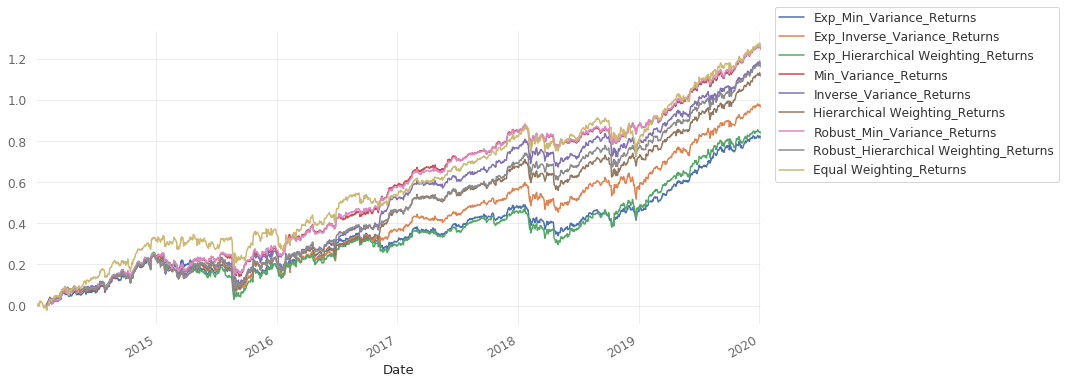

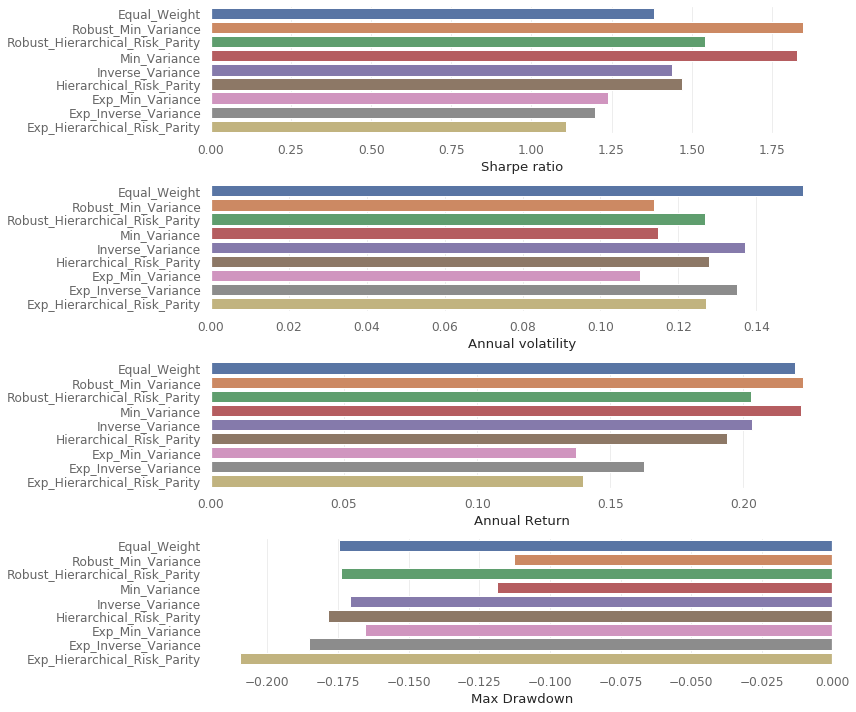

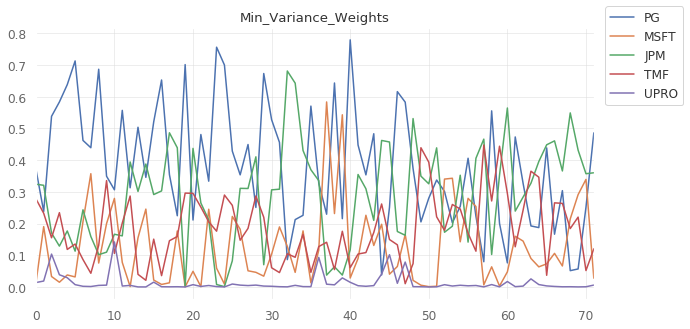

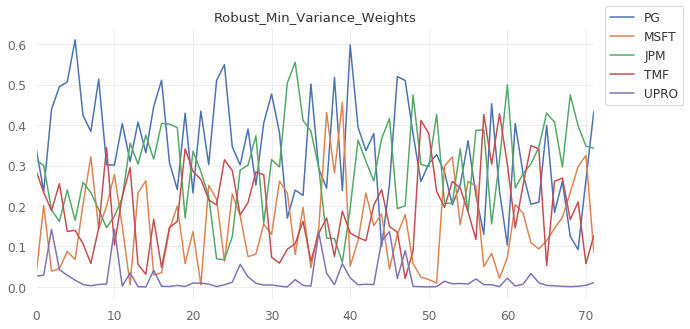

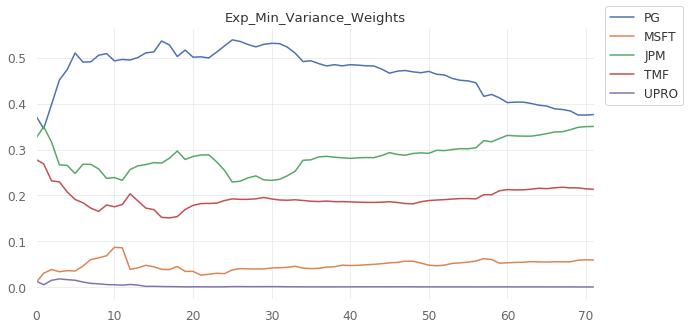

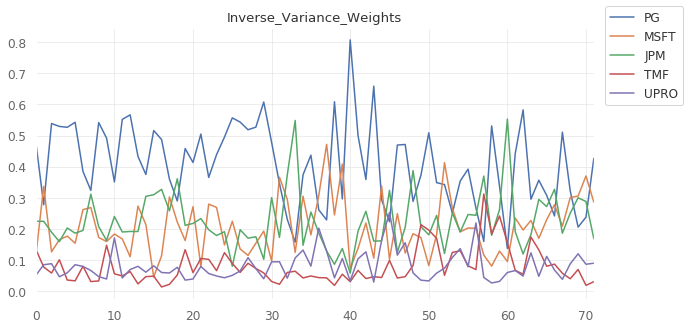

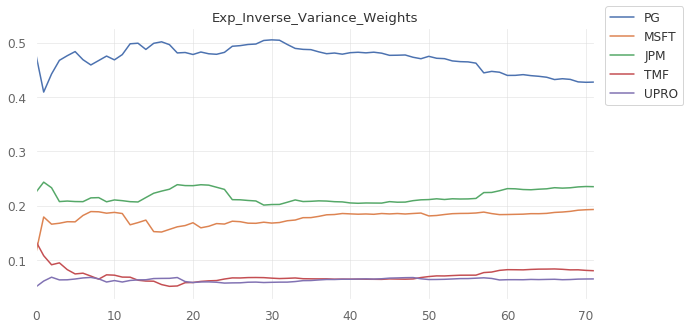

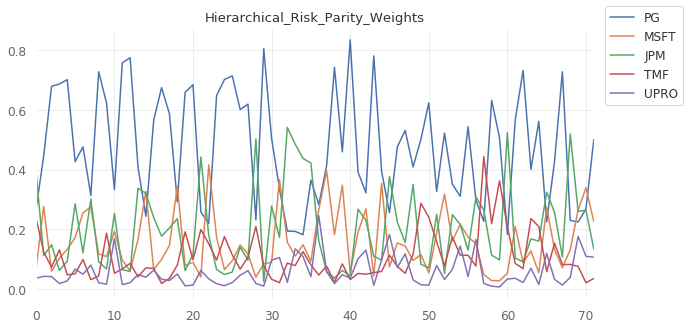

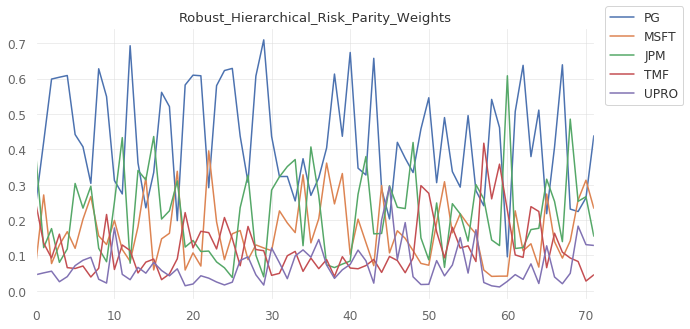

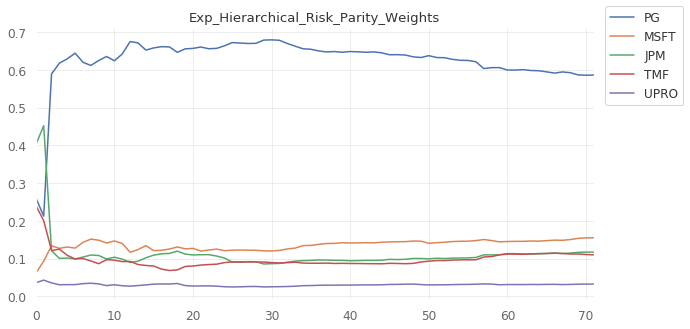

In [23]:
data = rets.copy()
data /= len(data.columns)
final_res = data.sum(axis=1)

port_returns1 = pd.concat([final_res, data1x, data3x, data11, data21, data31, data1z, data2z, data3z], axis=1)

port_returns1.columns = ['Equal_Weight', 'Robust_Min_Variance', 
                         'Robust_Hierarchical_Risk_Parity', 'Min_Variance', 
                         'Inverse_Variance', 'Hierarchical_Risk_Parity', 
                         'Exp_Min_Variance', 'Exp_Inverse_Variance', 'Exp_Hierarchical_Risk_Parity']

plt.figure(figsize=(13,6))
data1z.cumsum().plot(label='Exp_Min_Variance_Returns')
data2z.cumsum().plot(label='Exp_Inverse_Variance_Returns')
data3z.cumsum().plot(label='Exp_Hierarchical Weighting_Returns')
data11.cumsum().plot(label='Min_Variance_Returns')
data21.cumsum().plot(label='Inverse_Variance_Returns')
data31.cumsum().plot(label='Hierarchical Weighting_Returns')
data1x.cumsum().plot(label='Robust_Min_Variance_Returns')
data3x.cumsum().plot(label='Robust_Hierarchical Weighting_Returns')
final_res.cumsum().plot(label='Equal Weighting_Returns')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

fig, axs = plt.subplots(nrows=4, figsize=(12, 10))
colors = sns.color_palette(palette='Set3', n_colors=len(port_returns1))

sharpes = port_returns1.apply(pf.timeseries.sharpe_ratio)
sns.barplot(x=sharpes.values, y=sharpes.index, ax=axs[0])
axs[0].set(xlabel='Sharpe ratio')

vols = port_returns1.apply(pf.timeseries.annual_volatility)
sns.barplot(x=vols.values, y=vols.index, ax=axs[1])
axs[1].set(xlabel='Annual volatility')

aret = port_returns1.apply(pf.timeseries.annual_return)
sns.barplot(x=aret.values, y=aret.index, ax=axs[2])
axs[2].set(xlabel='Annual Return')
fig.tight_layout()

mdd = port_returns1.apply(pf.timeseries.max_drawdown)
sns.barplot(x=mdd.values, y=mdd.index, ax=axs[3])
axs[3].set(xlabel='Max Drawdown')
fig.tight_layout()
plt.show();

wt11.plot(figsize=(10,5))
plt.title('Min_Variance_Weights')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

wt1x.plot(figsize=(10,5))
plt.title('Robust_Min_Variance_Weights')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

wt1z.plot(figsize=(10,5))
plt.title('Exp_Min_Variance_Weights')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

wt21.plot(figsize=(10,5))
plt.title('Inverse_Variance_Weights')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

wt2z.plot(figsize=(10,5))
plt.title('Exp_Inverse_Variance_Weights')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

wt31.plot(figsize=(10,5))
plt.title('Hierarchical_Risk_Parity_Weights')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

wt3x.plot(figsize=(10,5))
plt.title('Robust_Hierarchical_Risk_Parity_Weights')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

wt3z.plot(figsize=(10,5))
plt.title('Exp_Hierarchical_Risk_Parity_Weights')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

In [79]:
qs.extend_pandas()

stock = data1x

In [80]:
stock[:5]

Date
2014-02-04   -0.002443
2014-02-05   -0.005438
2014-02-06    0.006448
2014-02-07    0.004321
2014-02-10    0.006528
dtype: float64

In [81]:
qs.reports.html(stock, "SPY", title='PG-MSFT-JPM-TMF-UPRO_Min_Var_Sld_Wndw')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
